In [1]:
import pandas as pa
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Consider the following dataset about homes that sold in a city in Iowa

hd = pa.read_csv('Data Sets/house-prices/train.csv')

hd.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
def onehot(df, feature):
    '''A function to do one-hot-encoding of a feature from a dataframe. df = dataframe'''

    v = list(set(df[feature])) # Make an iterable of the unique values for the feature
    
    for c in df.index: # cycle through the samples
        t = df.loc[c, feature]
        
        for test in v:
            if pa.isna(test):  # nan values are sort of a problem and have to be handled separately
                if pa.isna(t):
                    df.loc[c, '{}_nan'.format(feature)] = 1
                else:
                    df.loc[c, '{}_nan'.format(feature)] = 0
            else:
                if t == test:
                    df.loc[c, '{}_{}'.format(feature, test)] = 1  # Makes a new feature with name feature_value
                                                              # and codes it as a 1 if that was the value
                else:
                    df.loc[c, '{}_{}'.format(feature, test)] = 0  # and 0 otherwise
            
    return df.drop(feature, axis=1) # returns a dataframe with the encoded feature removed

In [4]:
# We can recode it using a dictionary and .map()
Street_dict = {'Grvl':0, 'Pave':1, 0:0, 1:1}  
# Note we include the trivial coding of the new values as otherwise if we run this twice
# it produces NaN values for the Street feature.
hd.Street = hd.Street.map(Street_dict)
set(hd.Street)

{0, 1}

In [5]:
hd2 = onehot(hd, 'Alley')
hd3 = onehot(onehot(onehot(hd2, 'ExterQual'), 'LotShape'), 'LandContour')
hd3.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Utilities,LotConfig,LandSlope,Neighborhood,...,ExterQual_Gd,ExterQual_Ex,LotShape_IR1,LotShape_Reg,LotShape_IR3,LotShape_IR2,LandContour_Low,LandContour_Bnk,LandContour_Lvl,LandContour_HLS
0,1,60,RL,65.0,8450,1,AllPub,Inside,Gtl,CollgCr,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2,20,RL,80.0,9600,1,AllPub,FR2,Gtl,Veenker,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,3,60,RL,68.0,11250,1,AllPub,Inside,Gtl,CollgCr,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,4,70,RL,60.0,9550,1,AllPub,Corner,Gtl,Crawfor,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,5,60,RL,84.0,14260,1,AllPub,FR2,Gtl,NoRidge,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [10]:
Utilities_dict = {'AllPub':1, 'NoSeWa':0, 1:1, 0:0}
hd3.Utilities = hd3.Utilities.map(Utilities_dict)
hd3.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Utilities,LotConfig,LandSlope,Neighborhood,...,ExterQual_Gd,ExterQual_Ex,LotShape_IR1,LotShape_Reg,LotShape_IR3,LotShape_IR2,LandContour_Low,LandContour_Bnk,LandContour_Lvl,LandContour_HLS
0,1,60,RL,65.0,8450,1,1,Inside,Gtl,CollgCr,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2,20,RL,80.0,9600,1,1,FR2,Gtl,Veenker,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,3,60,RL,68.0,11250,1,1,Inside,Gtl,CollgCr,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,4,70,RL,60.0,9550,1,1,Corner,Gtl,Crawfor,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,5,60,RL,84.0,14260,1,1,FR2,Gtl,NoRidge,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [12]:
hd4 = onehot(onehot(onehot(onehot(hd3, 'LotConfig'), 'LandSlope'), 'Neighborhood'), 'MSZoning')
hd4.head()

,Id,MSSubClass,LotFrontage,LotArea,Street,Utilities,Condition1,Condition2,BldgType,HouseStyle,...,Neighborhood_StoneBr,Neighborhood_Blmngtn,Neighborhood_Veenker,Neighborhood_Edwards,Neighborhood_NoRidge,MSZoning_RL,MSZoning_C (all),MSZoning_RH,MSZoning_RM,MSZoning_FV
0,1,60,65.0,8450,1,1,Norm,Norm,1Fam,2Story,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,2,20,80.0,9600,1,1,Feedr,Norm,1Fam,1Story,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,3,60,68.0,11250,1,1,Norm,Norm,1Fam,2Story,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,4,70,60.0,9550,1,1,Norm,Norm,1Fam,2Story,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,5,60,84.0,14260,1,1,Norm,Norm,1Fam,2Story,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [35]:
def condition(df, feature1, feature2):
    
    #This is onehot encoding but for features that represent the same things 
    # - i.e. where a sample could have two values identified.
    
    v = set(list(set(df[feature1])) + list(set(df[feature2])))  # Build a list of the possible outputs
    
    for c in df.index: # cycle through the samples
        t1 = df.loc[c, feature1]
        t2 = df.loc[c, feature2]
        
        for test in v:
            if (t1==test) or (t2==test):
                df.loc[c, '{}_{}'.format(feature1, test)] = 1  # Makes a new feature with name feature_value
                                                            # and codes it as a 1 if that was the value
            else:
                df.loc[c, '{}_{}'.format(feature1, test)] = 0  # and 0 otherwise
            
    return df.drop([feature1, feature2], axis=1) # returns a dataframe with the encoded feature removed

In [36]:
hd5 = condition(hd4, 'Condition1', 'Condition2')
hd5.head()

,Id,MSSubClass,LotFrontage,LotArea,Street,Utilities,BldgType,HouseStyle,OverallQual,OverallCond,...,Condition1_FeedrNorm,Condition1_Artery,Condition1_Feedr,Condition1_RRAn,Condition1_RRAe,Condition1_PosN,Condition1_RRNn,Condition1_RRNe,Condition1_Norm,Condition1_PosA
0,1,60,65.0,8450,1,1,1Fam,2Story,7,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2,20,80.0,9600,1,1,1Fam,1Story,6,8,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,3,60,68.0,11250,1,1,1Fam,2Story,7,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,4,70,60.0,9550,1,1,1Fam,2Story,7,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,5,60,84.0,14260,1,1,1Fam,2Story,8,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [122]:
hd6 = onehot(onehot(onehot(onehot(hd5, 'BldgType'), 'HouseStyle'), 'RoofStyle'), 'RoofMatl')
hd6.iloc[:5, 9:]

,YearRemodAdd,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,...,RoofStyle_Gambrel,RoofStyle_Hip,RoofMatl_Metal,RoofMatl_WdShngl,RoofMatl_ClyTile,RoofMatl_WdShake,RoofMatl_Tar&Grv,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Roll
0,2003,VinylSd,VinylSd,BrkFace,196.0,TA,PConc,Gd,TA,No,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1976,MetalSd,MetalSd,None,0.0,TA,CBlock,Gd,TA,Gd,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,2002,VinylSd,VinylSd,BrkFace,162.0,TA,PConc,Gd,TA,Mn,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1970,Wd Sdng,Wd Shng,None,0.0,TA,BrkTil,TA,Gd,No,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,2000,VinylSd,VinylSd,BrkFace,350.0,TA,PConc,Gd,TA,Av,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [123]:
keep = hd6.columns[hd6.dtypes!='object'][1:]
keep

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'Street', 'Utilities',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       ...
       'RoofStyle_Gambrel', 'RoofStyle_Hip', 'RoofMatl_Metal',
       'RoofMatl_WdShngl', 'RoofMatl_ClyTile', 'RoofMatl_WdShake',
       'RoofMatl_Tar&Grv', 'RoofMatl_CompShg', 'RoofMatl_Membran',
       'RoofMatl_Roll'],
      dtype='object', length=146)

In [124]:
# Check for NaN

for v in keep:
    if sum(np.isnan(hd6[v]))!=0:
        print(v)

LotFrontage
MasVnrArea
GarageYrBlt


In [125]:
# MasVnrArea and GarageYrBlt that are NaN probably mean 0 (i.e. no Garage and no Masonry)

for k in hd6.index:
    if np.isnan(hd6.loc[k, 'MasVnrArea']):
        hd6.loc[k, 'MasVnrArea']=0
    if np.isnan(hd6.loc[k, 'GarageYrBlt']):
        hd6.loc[k, 'GarageYrBlt']=0


In [126]:
keep = list(hd6.columns[hd6.dtypes!='object'][1:])
keep.remove('LotFrontage')   # There are some NaNs in LotFrontage. We could try to fill them in with a regression.
                             # Or we might check with a content expert and see if they should be 0
hd7 = hd6.loc[:, keep]
hd7.head()

,MSSubClass,LotArea,Street,Utilities,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,RoofStyle_Gambrel,RoofStyle_Hip,RoofMatl_Metal,RoofMatl_WdShngl,RoofMatl_ClyTile,RoofMatl_WdShake,RoofMatl_Tar&Grv,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Roll
0,60,8450,1,1,7,5,2003,2003,196.0,706,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,20,9600,1,1,6,8,1976,1976,0.0,978,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,60,11250,1,1,7,5,2001,2002,162.0,486,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,70,9550,1,1,7,5,1915,1970,0.0,216,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,60,14260,1,1,8,5,2000,2000,350.0,655,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [127]:
# Convert them to Numpy Arrays X for predictors and y for result

keep.remove('SalePrice')
X = np.array(hd7.loc[:, keep])
y = np.array(hd7.loc[:, 'SalePrice'])

In [128]:
import numpy.random as rn
from sklearn.linear_model import LinearRegression

In [129]:
# We shuffle the data using a random permutation

n = X.shape[0]
test = int(0.20*n)            # We will use a test set made up of 20% of the data from our sample
perm = rn.permutation(n)   
X = X[perm]
y = y[perm]
X_test = X[:test]       # Then create the test
y_test = y[:test]
X_train = X[test:]     # and train sets
y_train = y[test:]

In [130]:
reg = LinearRegression().fit(X_train, y_train)
print('Training R2: {}'.format(reg.score(X_train, y_train)))
print('Testing R2: {}'.format(reg.score(X_test, y_test)))

Training R2: 0.897959560211217
Testing R2: 0.8844231026551177


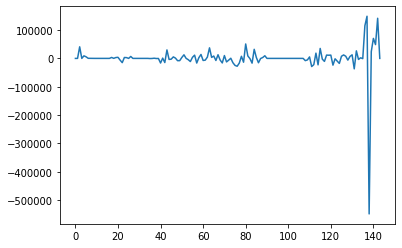

In [139]:
plt.plot(reg.coef_);

In [151]:
min(abs(reg.coef_)), max(abs(reg.coef_))

(0.0, 548708.3360944211)

In [156]:
sum( abs(reg.coef_)==0.0 )

2

In [133]:
from sklearn.linear_model import Ridge

In [195]:
ridge_reg = Ridge(alpha=1).fit(X_train, y_train)
print('Training R2: {}'.format(ridge_reg.score(X_train, y_train)))
print('Testing R2: {}'.format(ridge_reg.score(X_test, y_test)))

Training R2: 0.8874892969912476
Testing R2: 0.8900129673320429


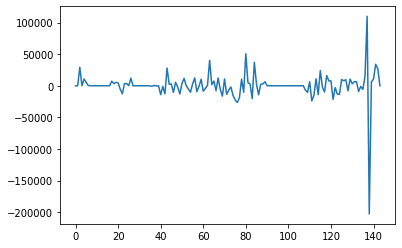

In [196]:
plt.plot(ridge_reg.coef_);

In [197]:
min(abs(ridge_reg.coef_)), max(abs(ridge_reg.coef_))

(0.0, 202615.3054125202)

In [198]:
sum(reg.coef_**2) - sum(ridge_reg.coef_**2)

313397341248.0099

In [199]:
sum(abs(ridge_reg.coef_)==0.0)

20

In [200]:
from sklearn.linear_model import Lasso

In [183]:
lasso_reg = Lasso(alpha=100).fit(X_train, y_train)
print('Training R2: {}'.format(lasso_reg.score(X_train, y_train)))
print('Testing R2: {}'.format(lasso_reg.score(X_test, y_test)))

Training R2: 0.8891508803381438
Testing R2: 0.8978404128153449


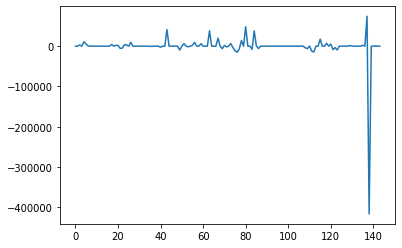

In [184]:
plt.plot(lasso_reg.coef_)

In [185]:
min(abs(lasso_reg.coef_)), max(abs(lasso_reg.coef_))

(0.0, 416277.7752980354)

In [186]:
sum(abs(lasso_reg.coef_)==0.0)

67